<a href="https://colab.research.google.com/github/pakddo/de-openchat/blob/main/DE_openchat_step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리
- 데이터 출처 : 카카오톡 데이터엔지니어 오픈 채팅방

In [3]:
import pandas as pd
import re
from dateutil.parser import parse

from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
## 텍스트 전처리 Step 0 : 파일에 포함된 모든 텍스트를 하나로 합치고 시간 기준으로 자름
f = open("/content/drive/MyDrive/2021.10.05_DE-openchat/한국 데이터 엔지니어 모임 315 님과 카카오톡 대화", 'r')

text_list = []
while True:
    line = f.readline()
    if not line: break 
    line = line.replace('\ufeff', '')       
    line = re.sub(r'(202[0-1]+)년 ([0-9]+)월 ([0-9]+)일 (오전|오후) ([0-9]+:[0-9]+), ', 
          r'<return>\1-\2-\3 \5\4<tab>',
          line, 1)
    line = line.replace('오전<tab>','AM<tab>')\
               .replace('오후<tab>','PM<tab>')
    line = line.replace(' : ', '<tab>', 1)
    line = line.replace('\n', '<br>')    
    line = line.rstrip('<br> ')    
    text_list.append(line)   
f.close()
text = ''.join(text_list)
text_split = text.split('<return>')

In [5]:
## 텍스트 전처리 Step 1 : 줄바꿈 및 칼럼 구분자 정리
text_list_1st = []
for line in tqdm(text_split):     
    line = line.split('<tab>')  
    text_list_1st.append(line)

  0%|          | 0/11308 [00:00<?, ?it/s]

In [6]:
text_list_1st = text_list_1st[2:]
df = pd.DataFrame(text_list_1st).reset_index()
df_target_text = df.rename(columns={0:'timestamp', 1:'chat_name', 2:'full_text'}).copy()

In [10]:
df_a = df[['index', 0, 1]].rename(columns={0:'timestamp', 1:'chat_name'}).copy()

full_columns = []
full_columns.append('index')
list_columns = [x for x in range(2, 6)]
full_columns.extend(list_columns)

df_b = df[full_columns].copy()
df_b = df_b.fillna('')
df_b['full_text'] = df_b[list_columns].apply(lambda x: ''.join(x), axis=1)
df_b = df_b[['index', 'full_text']].copy()
df_target_text = df_a.merge(df_b, how='left')
df_target_text.fillna('', inplace=True)

## 텍스트 전처리 Step 4 : chat_name 칼럼 생성
df_target_text['chat_name'] = df_target_text.chat_name.progress_apply(lambda x: x.replace('님이 들어왔습니다.\n 운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에 제한이 있을 수 있습니다. 자세히 보기', '').replace('님이 들어왔습니다.', '').replace('님이 나갔습니다.', ''))
df_target_text['chat_name'] = df_target_text['chat_name'].str.strip()
df_target_text['timestamp'] = df_target_text.timestamp.progress_apply(lambda x : parse(x , fuzzy_with_tokens=True)[0])
df_target_text = df_target_text[['timestamp', 'chat_name', 'full_text']].copy()
df_target_text = df_target_text[(df_target_text.chat_name != '') 
                                & (df_target_text.full_text != '')].copy()


## 텍스트 전처리 Step 5 : 인덱스 재설정                                
df_target_text = df_target_text.reset_index(drop=True)
df_target_text.index = df_target_text.index + 1
df_target_text.reset_index(inplace=True)

  0%|          | 0/11306 [00:00<?, ?it/s]

  0%|          | 0/11306 [00:00<?, ?it/s]

# 전처리 데이터 저장

In [11]:
!pip install xlsxwriter

     |████████████████████████████████| 148 kB 6.4 MB/s 


In [12]:
df_target_text.to_excel('/content/drive/MyDrive/2021.10.05_DE-openchat/target_text.xlsx', engine='xlsxwriter')

# 단순 통계
- 채팅 많이 한 사람

In [13]:
rank = df_target_text.groupby('chat_name').size().to_frame(name='count').reset_index()
rank.sort_values('count', ascending=False, inplace=True)
rank = rank.head(50)

In [14]:
rank

,chat_name,count
172,조승현,664
56,개집,646
48,prodo,606
160,월세100만타자,596
179,짱짱,491
116,무늬만엔지니어,466
11,CharSyam,431
62,긔긔,348
134,소소한 데엔,292
126,비전메디컬,260


In [15]:
## 채팅인원 전체
print(df_target_text.chat_name.unique())

['히오스 노바' '루루' '짱짱' 'CharSyam' '개집' '비전메디컬' '만두전골조아' '데린이' '소소' '오이대당근'
 '무늬만엔지니어' 'celery' 'prodo' '딕구' '데린이동생' '데엔 꿈나무' '토끼' '김성준' '카카오보내줘'
 '데이터엔지니어-BK' '새벽' '데엔쟈누' '데엔쓰' '심장이없어' '조승현' '변성윤' '공룡' '데린이 백엔드개발자'
 '올인원' '랄라' '쫑긋' '데이터조무사' '카프카프카' 'Seed42' '몽고DB는몽골것이아니야' '루이스' '연서빠'
 '학생 엔지니어' '카프' '긔긔' '마도사' '카프카' '월세100만타자' '무념무상..' 'David35xxxv'
 'sparkkkk' '알파카' '데애기' '소희' '라이언' '데니어' '데싸학부생' '게발자' '이게아니야' '소소한 데엔'
 '월급루팡/개발자/건물주가꿈' '오자영(오드리)' '11' 'ShootingStar' '준' '호롤라' '/데이터과학자 지망'
 'af' '포비' '데친이' '마개' '험프리' '윤종원' 'J' '딩딩' '덴' '경양식돈까스' '딩가딩가'
 '수지조아/green' '데엔' '데이터레이크' 'juno' 'daniel' '데엔주니어' '스린이' '헤헷' '다빈치' '푸푸'
 'ㅆ' '파랑파랑' '카일' '주니어엔지니어' '코린이' 'EbayDE' '빅린이' '데엔진짜하고싶은데엔' 'Enzo' '데엔좋아'
 '쿠루쿠루' '하이' '베어린' 'BA' 'hye' '탱쟈' '김영하' 'Duggy' 'AB' '김정의' '언젠간꼭' '아이스크린'
 '후잇' '화이팅빌런' 'nv' '주니어' '쥬스' '킁쿵' '인턴' '야호' '데엔할랭' '곰' '쿠쿠' '새싹'
 'HADOOP_USER_NAME' '벨리' 'Rainy' '데린이친구' '전종희' '야옹' 'bleum' '카이' '데장'
 '초보 dater' 'Muyaho~' '데이터 엔지니어 준비중' '데엔이되고싶은백엔드' '제이그루비' '110_' '흰색'
 'Berkl' '섭섭해'

# WordCloud

In [16]:
## 환경 설정
!pip install konlpy wordcloud
!apt-get update -qq
!apt-get install fonts-nanum* -qq

     |████████████████████████████████| 19.4 MB 65.5 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 448 kB 61.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nan

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [19]:
rank_list = [(x[0], x[1]) for i, x in rank.iterrows()]

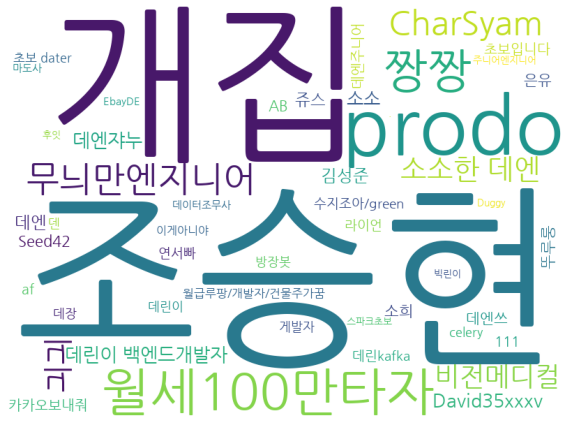

In [21]:
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(dict(rank_list))
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()